In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 3

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [2]:
data = pd.read_csv("/kaggle/input/diabetic-retinopathy-resized/trainLabels.csv")
data.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [3]:
data.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [4]:
data['image_name'] = [i+".jpeg" for i in data['image'].values]
data.head()

,image,level,image_name
0,10_left,0,10_left.jpeg
1,10_right,0,10_right.jpeg
2,13_left,0,13_left.jpeg
3,13_right,0,13_right.jpeg
4,15_left,1,15_left.jpeg


0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64

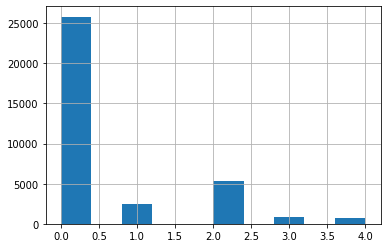

In [5]:
data['level'].hist()
data['level'].value_counts()

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train, val = train_test_split(data, test_size=0.15)

In [8]:
train.shape, val.shape

((29857, 3), (5269, 3))

In [9]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [10]:
import cv2
def load_ben_color(image):
    IMG_SIZE = 224
    sigmaX=10
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    return image

In [11]:
data_gen = ImageDataGenerator(rescale=1/255.,
                              zoom_range=0.15,
                              fill_mode='constant',
                              cval=0.,
                              horizontal_flip=True,
                              vertical_flip=True,
                              preprocessing_function=load_ben_color)

In [12]:
# batch size
bs = 32

train_gen = data_gen.flow_from_dataframe(train, 
                                         "../input/diabetic-retinopathy-resized/resized_train/resized_train/",
                                         x_col="image_name", y_col="level", class_mode="raw",
                                         batch_size=bs,
                                         target_size=(224, 224))
val_gen = data_gen.flow_from_dataframe(val,
                                       "../input/diabetic-retinopathy-resized/resized_train/resized_train/",
                                       x_col="image_name", y_col="level", class_mode="raw",
                                       batch_size=bs,
                                       target_size=(224, 224))

Found 29857 validated image filenames.
Found 5269 validated image filenames.


### ResNet50

In [ ]:
from keras.applications.resnet50 import ResNet50
# from keras.applications.mobilenet import MobileNet
# from keras.applications.densenet import DenseNet121
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.xception import Xception
# from keras.applications.nasnet import NASNetMobile, NASNetLarge
# from keras.applications.efficientnet import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7 
import keras.layers as L
from keras.models import Model

In [ ]:
base_model = ResNet50(weights='../input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                   include_top=False,
                   input_shape=(224, 224, 3))
# MobileNet, DenseNet121, VGG19, /InceptionV3, Xception, NASNetMobile, NASNetLarge, EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
x = base_model.output
x = L.GlobalMaxPooling2D()(x)
x = L.BatchNormalization()(x)
x = L.Dropout(0.2)(x)
x = L.Dense(1024, activation="relu")(x)
x = L.Dropout(0.1)(x)
x = L.Dense(64, activation="relu")(x)
predictions = L.Dense(5, activation='softmax')(x)

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [15]:
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
for layer in base_model.layers[:-20]: layer.trainable = False

In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [19]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
model_chk = ModelCheckpoint("vgg16_model.h5", save_best_only=True, monitor="val_accuracy")
reduce_lr = ReduceLROnPlateau()

In [20]:
model.fit_generator(train_gen, train_gen.n // bs,
                    validation_data=val_gen, validation_steps=val_gen.n // bs,
                    epochs=30, workers=4, callbacks=[model_chk])

Epoch 1/30
933/933 [==============================] - 658s 705ms/step - loss: 0.8304 - accuracy: 0.7334 - val_loss: 0.8007 - val_accuracy: 0.7372
Epoch 2/30
933/933 [==============================] - 639s 685ms/step - loss: 0.7639 - accuracy: 0.7448 - val_loss: 0.8354 - val_accuracy: 0.7388
Epoch 3/30
933/933 [==============================] - 635s 680ms/step - loss: 0.7417 - accuracy: 0.7510 - val_loss: 0.7128 - val_accuracy: 0.7371
Epoch 4/30
933/933 [==============================] - 634s 679ms/step - loss: 0.7307 - accuracy: 0.7534 - val_loss: 1.7067 - val_accuracy: 0.7384
Epoch 5/30
933/933 [==============================] - 630s 675ms/step - loss: 0.7274 - accuracy: 0.7543 - val_loss: 0.9492 - val_accuracy: 0.7395
Epoch 6/30
933/933 [==============================] - 628s 673ms/step - loss: 0.7181 - accuracy: 0.7575 - val_loss: 0.9978 - val_accuracy: 0.7374
Epoch 7/30
933/933 [==============================] - 631s 676ms/step - loss: 0.7112 - accuracy: 0.7611 - val_loss: 1.3209 -

In [21]:
model.evaluate_generator(val_gen, steps=val_gen.n/bs, verbose=1)

165/164 [==============================] - 110s 668ms/step


[1.1455894708633423, 0.7382805347442627]

In [22]:
from keras.models import load_model
model = load_model("vgg16_model.h5")

test some instances

In [23]:
from PIL import Image
im = Image.open("../input/diabetic-retinopathy-resized/resized_train/resized_train/" + val.iloc[0].image_name)
im = np.array(im.resize((224, )*2, resample=Image.LANCZOS))
im.shape

(224, 224, 3)

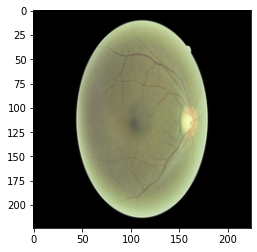

In [24]:
import matplotlib.pyplot as plt
plt.imshow(im)

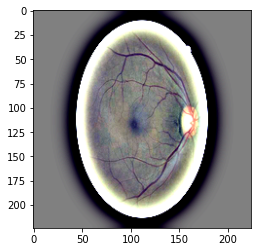

In [25]:
plt.imshow(load_ben_color(im))

In [26]:
print("predicted:", np.argmax(model.predict(load_ben_color(im).reshape(1, *im.shape))[0]))
print("actual:", val.iloc[0].level)

predicted: 0
actual: 0
